# Noise Model

In this notebook we take a closer look at the noise model and how it holds up under discretization.

## Imports

In [1]:
import sys
sys.path.insert(0, "../source/")
sys.path.insert(0, "../models/AdvectionDiffusion/settings/AdvectionDiffusion_FEniCS")
sys.path.insert(0, "../models/AdvectionDiffusion/Navigators")
sys.path.insert(0, "../models/AdvectionDiffusion/Detectors")

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

from InverseProblem import InverseProblem
from InverseProblemBayesNeumann import InverseProblemBayesNeumann as InverseProblemBayes
#from InverseProblemBayes import InverseProblemBayes 

from FOM_stationary import FOM_stationary as FOM
from OEDUtility import OEDUtility
from Drone import Drone as Drone

from DetectorPointwise import DetectorPointwise
from DetectorUniform import DetectorUniform
from DetectorGaussian import DetectorGaussian
from DetectorTruncGaussian import DetectorTruncGaussian
from NavigationCircle import NavigationCircle as Navigation

import time
tStart_notebook = time.time()

## User settings

In [2]:
centers = [[0.4, 0.6], [0.6, 0.4]]
var_prior = 1 # set to a high value (1e+6) to test convergence in noise-free situations

n_test_2d = 100  # resolution for 2D plots (50: ~1 min runtime for dt = 0.01)

n_steps = 100

sigma = 0.05  # std deviation for gaussian-type measurements. Get pointwise data for sigma -> 0
radius = 0.05  # truncation radius for truncation-style measurements

meshDim = 50  # discretization parameter (1D) for FOM
meshDim_drone = 10  # discretization parameter (1D) for subdomain in truncation-type measurements
polyDim = 3

## Setup

For the purposes of this notebook we go back to a simple flight in a circle. It's not actually important here, and can be switched out for any other flight path parameterization. 

In [3]:
# initialize full-order model
tStart = time.time()
fom = FOM(meshDim = meshDim, centers=centers, polyDim=polyDim)
print("Runtime of this block: {} s".format(time.time()-tStart))
n_para = fom.n_para

# set a prior
prior_mean = np.zeros((n_para,))
prior_covar = var_prior*np.eye(n_para)
fom.set_prior(prior_mean=prior_mean, prior_covar=prior_covar)



Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Runtime of this block: 4.407306909561157 s


In [4]:
# NavigationCircle was imported as Navigation
navigation = Navigation(grid_t = np.linspace(0, 4, n_steps))

# point-wise measurements
detector = DetectorPointwise(fom)
#detector = DetectorUniform(fom, radius=radius, meshDim=meshDim_drone)

# initialize drone
drone = Drone(detector=detector, navigation=navigation)

## Inverse problems

We are primarily considering two types of inverse problems: the deterministic and the Bayesian. There are a lot of parallels between them, to the point that for the optimization we can treat them equivalently. The main difference lies in where the matrix over which we optimize (i.e. the information matrix / the posterior covariance matrix) comes from. 

In [5]:
# compute one solution for nicer visualization below
para_true = np.ones((n_para,))
state = fom.solve(parameter=para_true)

# fly in a circle
alpha = np.array([0.25, 0.2])
flight = drone.plan_flight(alpha=alpha)

# measure data
data = drone.measure(flight=flight, state=state)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


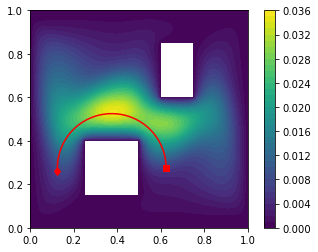

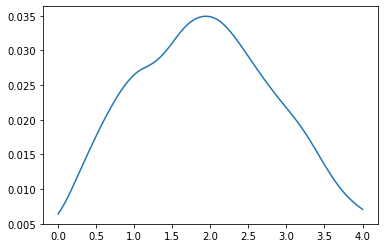

In [6]:
flightpath, grid_t = flight.flightpath, flight.grid_t

fom.plot(state)
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")
plt.plot([flightpath[0, 0]], [flightpath[0, 1]], color="r", marker="s")
plt.plot([flightpath[-1, 0]], [flightpath[-1, 1]], color="r", marker="d")

fig, ax = plt.subplots(1,1)
ax.plot(grid_t, data)

### Deterministic
This is the model form that we've been using in the previous notebooks (without telling you). It's a bit easier to explain. Suppose we know the data $d$ lies in a Hilbert space $\mathcal{H} \subset L^2([0, T])$. Then, given observational data $d_{obs}$, we can pose the inverse problem as
$$
\min_{m} c_s \| d-d_{obs}\|_{\mathcal{H}}^2 + \|m-m_{pr}\|_{\Sigma_{pr}^{-1}}^2
\quad \text{such that $d$ is the measurement of the state $u(m)$}
$$
where $c_2 > 0$ is a scaling parameter. After discretization in time, the Hessian $\mathbf{H}$ of this problem, a.k.a. the \red{inverse?} Fisher information matrix, is
$$
\mathbf{H} = c_s \mathcal{F}^T \mathbf{I}_{\mathcal{H}} \mathcal{F} + \Sigma_{pr}^{-1}
$$
where $\mathbf{I}_{\mathcal{H}}$ is the inner product matrix for $\mathcal{H}$ and $\mathcal{F}$ the discretized parameter-to-observable map. If, abusing notation, we define
$$
\Sigma_{noise}^{-1} := c_s \mathbf{I}_{\mathcal{H}},
$$
then we arrive at the same matrix structure as in the Bayesian setting. The only "complication" we have is to choose the Hilbert space $\mathcal{H}$. The simplest choice that doesn't require any knowledge about the properties of the data beyond $d \in L^2([0,T])$ is to choose $\mathcal{H} = L^2([0,T])$ (duh!). In this case we have
$$
\Sigma_{noise}^{-1} := c_s \mathbf{M},
$$
where $\mathbf{M}$ is the mass matrix for the discretization of $\mathcal{H}$. Another obvious choice is $\mathcal{H} = H^1([0,T])$, in which case
$$
\Sigma_{noise}^{-1} := c_s c_d \mathbf{A} + c_s \mathbf{M},
$$
with stiffness matrix $\mathbf{A}$ and a diffusion scaling coefficient $c_d$. This choice penalizes large derivativess in the data, as caused by noise, and is therefore attractive. It can however be tricky in the time continuous limit to show that the data is indeed weakly differentiable.

In [7]:
inversion = InverseProblem(fom, drone)
inversion.set_noise_model(c_scaling = 1e+6, c_diffusion=0)
print("Norm of the data:", np.sqrt(inversion.compute_noisenorm2(data)))

Norm of the data: 48.75142242481111


In [8]:
posterior = inversion.compute_posterior(flight=flight)
covar = posterior.compute_covariance()
covar

Calling FFC just-in-time (JIT) compiler, this may take some time.


array([[ 0.0008821 , -0.00057475],
       [-0.00057475,  0.00256532]])

### Bayesian setting

In [9]:
inversionBayes = InverseProblemBayes(fom, drone)
inversionBayes.set_noise_model(c_scaling = 1e+3, c_diffusion = 0.1, c_boundary = (0.1)**2)
print("Norm of the data:", np.sqrt(inversionBayes.compute_noisenorm2(data)))

Norm of the data: 51.21669741843358


In [10]:
# samples = inversionBayes.sample_noise(n_samples = 50)
# fig, axs = plt.subplots(1,2, figsize = (12, 4))

# for i in range(samples.shape[1]):
#     axs[0].plot(grid_t, samples[:, i])
#     axs[1].plot(grid_t, data + samples[:, i])

In [11]:
# posterior = inversionBayes.compute_posterior(flight=flight)
# covar = posterior.compute_covariance()
# covar

**Welcome back!**
Unfortunately it still seems like the noise model in the Bayesian setting is not converging. I'm very surprised by it, and don't understand why. Here are the possible reasons I can think of:
- there's an error in the computation (everything is converging nicely in the noise-test notebook)
- it's not good to use the last two entries for computing the derivative, and one should instead use a fixed h
- the data is not converged
- mesh size (see last test below)

I think, most likely, it's a combination of the mesh and taking the last two elements.

**Also of note:**
I'm starting to run out of memory when making the dimension larger than 200

In [12]:
def noisenorm2(n_steps):
    # NavigationCircle was imported as Navigation
    navigation = Navigation(grid_t = np.linspace(0, 4, n_steps))

    # point-wise measurements
    detector = DetectorPointwise(fom)
    #detector = DetectorUniform(fom, radius=radius, meshDim=meshDim_drone)

    # initialize drone
    drone = Drone(detector=detector, navigation=navigation)

    # fly in a circle
    alpha = np.array([0.25, 0.2])
    flight = drone.plan_flight(alpha=alpha)

    # measure data
    data = drone.measure(flight=flight, state=state)

    inversionBayes = InverseProblemBayes(fom, drone)
    inversionBayes.set_noise_model(c_scaling = 1e+3, c_diffusion = 0.01, c_boundary = 1000)

    return inversionBayes.compute_noisenorm2(data)

In [13]:
steps_test = np.arange(10, 500, 10)
vals_test = np.zeros(steps_test.shape[0])

for i in range(steps_test.shape[0]):
    vals_test[i] = noisenorm2(n_steps = steps_test[i])

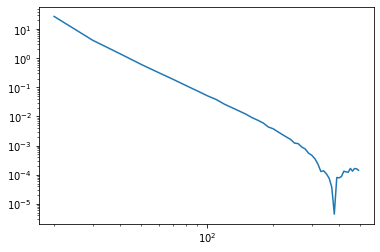

In [14]:
plt.loglog(steps_test[1:], np.abs(vals_test[1:]-vals_test[:-1]))

In [15]:
fom.nFE

31853

In [16]:
import fenics as dl

In [17]:
help(dl.FiniteElement)

Help on class FiniteElement in module ufl.finiteelement.finiteelement:

class FiniteElement(ufl.finiteelement.finiteelementbase.FiniteElementBase)
 |  FiniteElement(family, cell=None, degree=None, form_degree=None, quad_scheme=None, variant=None)
 |  
 |  The basic finite element class for all simple finite elements.
 |  
 |  Method resolution order:
 |      FiniteElement
 |      ufl.finiteelement.finiteelementbase.FiniteElementBase
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getnewargs__(self)
 |      Return the arguments which pickle needs to recreate the object.
 |  
 |  __init__(self, family, cell=None, degree=None, form_degree=None, quad_scheme=None, variant=None)
 |      Create finite element.
 |      
 |      *Arguments*
 |          family (string)
 |             The finite element family
 |          cell
 |             The geometric cell
 |          degree (int)
 |             The polynomial degree (optional)
 |          form_degree (int)
 |             Th